<a href="https://colab.research.google.com/github/chalsai/bank_analysis/blob/main/Week_5_Bank_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project description
Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.
We need to predict whether a customer will leave the bank soon. You have the data on clients’ past behavior and termination of contracts with the bank.
Build a model with the maximum possible F1 score. To pass the project, you need an F1 score of at least 0.59. Check the F1 for the test set.
Additionally, measure the AUC-ROC metric and compare it with the F1.

### Download and prepare the data. Explain the procedure.

In [1]:
#Let us first import the relevant libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from joblib import dump
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

In [2]:
#Now, let us load the data
df = pd.read_csv('https://bit.ly/2XZK7Bo')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
#Let us do some preliminary examination of the data:
df.head()
df.isna().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Our target is Exited. For our purposes, some of the columns like RowNumber, CustomerId and Surname are not going to be useful features. I will remove them. Apart from that, we need to consider some options for dealing with the null values in the Tenure feature. Since we are going to be using metrics like MSE I think using the mean to impute the missing values should not affect the performance of our models. Then, I will convert it to type int since it's not needed to be a float.

In [4]:
#Remove RowNum, CusomberID, surname
df = df.drop(['RowNumber','CustomerId','Surname'], axis = 1)
df.info()

#replace missing Tenure with mean score
df['Tenure']= df['Tenure'].fillna(df['Tenure'].mean())
#change Tenure into Interger
df['Tenure'] = df['Tenure'].astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [5]:
#Quick check to see if the values got filled:
df.info()
#They are filled, now let's encode categorical variables and normalize the data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [6]:
scaler = StandardScaler() 
#OHE
df = pd.get_dummies(df, drop_first=True)
#creating a features dataframe and a target dataframe
features = df.drop(columns=['Exited'])
target =  df['Exited']
#Now, we will split the data into training, testing and validation sets. Of the base dataset,
#I will split 20% for testing and 80% for training.
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.20, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.2, random_state=12345 )


In [7]:
#Let's take a look at the split:
print(len(features_train))
print(len(target_train))
print(len(features_test))
print(len(target_test))
print(len(features_valid))
print(len(target_valid))


6400
6400
2000
2000
1600
1600


    
Ok, data is splitted correctly.


In [8]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [9]:
to_normalize = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts']
scaler = StandardScaler()
scaler.fit(features_train[to_normalize])
features_train.loc[:,to_normalize] = scaler.transform(features_train[to_normalize])
features_valid.loc[:,to_normalize] = scaler.transform(features_valid[to_normalize])
features_test.loc[:,to_normalize] = scaler.transform(features_test[to_normalize])


One hot encoding was required because the categorical variable words don't mean anything to ML models. Allowing the 'inverse' of each data type (for example allowing both male and female coulmns to remain) will damage our outcomes since there will be high correlation between them. Therefore, it makes sense to 'drop first' and only let one of them remain. Similarly, we don't need France, Germany and Spain coulmns since a row not being 1 for Germany *and* Spain implies that it is France. After splitting, I checked to see if the splits make sense, and they do. The sample size is also good. 

Finally, I decided to normalize the numeric columns since doing so can not hurt, and can greatly help our evaluation metrics.

### Examine the balance of classes. Train the model without taking into account the imbalance. Briefly describe your findings.

In [10]:
#First, let's look at the class imbalance (if there is any) briefly:
print(df[df['Exited'] == 1]['Exited'].count())
print(df[df['Exited'] == 0]['Exited'].count())

2037
7963



    
Yes, we have imbalance problem.


Clearly, there is an apparent imbalance, almost a 1:4 ratio. Now, let's see how much this affects our model's performance.

In [11]:
#Let's pretend like we don't know anything about class imbalance:
LogRegModImb = LogisticRegression(solver='liblinear', random_state=12345)
LogRegModImb.fit(features_train,target_train)
print('Accuracy', LogRegModImb.score(features_valid, target_valid))
print('f1 score:' ,f1_score(target_valid, LogRegModImb.predict(features_valid)))
print('AUC:', roc_auc_score(target_valid, LogRegModImb.predict_proba(features_valid)[:,1]))

Accuracy 0.8175
f1 score: 0.3145539906103286
AUC: 0.7634576873261729


We have a accuracy of 0.81, f1 score of 0.31, and AUC of 0.76 when we do not account for imbalance and use logistic regression. We don't need to check Random Forest and Decision Tree because if the imbalance affects the results of Logistic Regression, it will naturally affect the results of Random Forest and Decision Tree since they do not perform well on imbalanced data sets.


In [12]:
#Now, let's balance the data and see how the logistic regression improves
LogRegModBal = LogisticRegression(solver='liblinear', random_state=12345, class_weight='balanced')
LogRegModBal.fit(features_train,target_train)
print('Accuracy', LogRegModBal.score(features_valid, target_valid))
print('f1 score:' ,f1_score(target_valid, LogRegModBal.predict(features_valid)))
print('AUC:',roc_auc_score(target_valid, LogRegModBal.predict_proba(features_valid)[:,1]))

Accuracy 0.70875
f1 score: 0.46924829157175396
AUC: 0.7666587784453079


It's great that I fixed a random_state.


We have a accuracy of 0.70, f1 score of 0.47, and AUC of 0.77 when we do account for imbalance and use logistic regression. The accuracy has gone down from balancing but the f1 score has improved.

Now that we know the impact of balancing, let's proceed with some strategies to account for that.

### Improve the quality of the model. Make sure you use at least two approaches to fixing class imbalance. Use the training set to pick the best parameters. Train different models on training and validation sets. Find the best one. Briefly describe your findings.

#### Let's try upsampling first.

In [13]:
#Upsampling function from exercise
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

upsampled_LogReg_model =LogisticRegression(random_state=12345,solver='liblinear')
upsampled_LogReg_model.fit(features_upsampled, target_upsampled)
upsampled_LogReg_predicted_valid = upsampled_LogReg_model.predict(features_valid)




print('Accuracy', upsampled_LogReg_model.score(features_valid, target_valid))
print('f1 score:' ,f1_score(target_valid, upsampled_LogReg_predicted_valid))
print('AUC:',roc_auc_score(target_valid, upsampled_LogReg_model.predict_proba(features_valid)[:,1]))

Accuracy 0.454375
f1 score: 0.39332870048644897
AUC: 0.7678598237618673


  
Ok, upsampling was done correctly.


Only upsampling makes our f1 score 0.393. This isn't as good as the in built balanced feature of the Logisitic regression model. 

#### Let's try downsampling now.

In [14]:
#Downsampling function from exercise
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

down_LogReg_model =LogisticRegression(random_state=12345,solver='liblinear')
down_LogReg_model.fit(features_downsampled, target_downsampled)
down_LogReg_predicted_valid = down_LogReg_model.predict(features_valid)

print("F1:", f1_score(target_valid, down_LogReg_predicted_valid))
print('Accuracy:', down_LogReg_model.score(features_valid, target_valid))
print("AUC-ROC:", roc_auc_score(target_valid, down_LogReg_model.predict_proba(features_valid)[:,1]))


F1: 0.39145416953824946
Accuracy: 0.448125
AUC-ROC: 0.7647757836693462


Only downsampling makes our f1 score 0.391. This isn't as good as the in built balanced feature of the Logisitic regression model and is almost the same as upsampling.

#### Let's try using decision trees.

In [15]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [16]:
depth_param = {'max_depth':range(1,25)}
DecTreeMod = DecisionTreeClassifier(random_state=12345)
DecTreeModOpt = GridSearchCV(DecTreeMod,depth_param)
DecTreeModOpt.fit(features_train, target_train)
print(DecTreeModOpt.best_estimator_)
DecTreeModOpt_predicted_valid = DecTreeModOpt.predict(features_valid)
print("F1:", f1_score(target_valid, DecTreeModOpt_predicted_valid))
print('Accuracy:', DecTreeModOpt.score(features_valid, target_valid))
print("AUC-ROC:", roc_auc_score(target_valid, DecTreeModOpt.predict_proba(features_valid)[:,1]))


DecisionTreeClassifier(max_depth=6, random_state=12345)
F1: 0.5176991150442477
Accuracy: 0.86375
AUC-ROC: 0.8132692606191999


Just from using decision trees with optimized hyper parameters, our f1 score 0.51. This is better than the in built balanced feature of the Logisitic regression model, but not by much. 

#### Let's try using Random Forests.

In [17]:
depth_param = {'max_depth':range(1,10), 'n_estimators':range(1,50)}
RandForestMod = RandomForestClassifier(random_state=12345)
RandForestOpt = GridSearchCV(RandForestMod,depth_param)
RandForestOpt.fit(features_train, target_train)
print(RandForestOpt.best_estimator_)
RandForestOpt_predicted_valid = RandForestOpt.predict(features_valid)
print("F1:", f1_score(target_valid, RandForestOpt_predicted_valid))
print('Accuracy', RandForestOpt.score(features_valid, target_valid))
print("AUC-ROC:", roc_auc_score(target_valid, RandForestOpt.predict_proba(features_valid)[:,1]))



RandomForestClassifier(max_depth=8, n_estimators=40, random_state=12345)
F1: 0.5431578947368422
Accuracy 0.864375
AUC-ROC: 0.8501874088719589


Random forests gives us a f1 score of 0.53, although it took a very long time to run this chunk of code. If run time is a priority, the parameter space needs to be greatly reduced. However, we have come across an issue. We need an f1 score of at least 0.59, and we have already done an exhaustive search over a huge parameter space. Let us try to keep one parameter constant and increase the range of the other parameter to see if that can help us improve our score. For the above model, max_depth of 8 gave us the best result. Let's keep that constant and increase the range of n_estimators and try again. Most importantly, let us add the argument: 'class weight = balanced' since simply increasing the parameter space alone is most likely not going to increase our f1 score by so much.

#### Random forest has the best performance as per the f1 score

In [18]:
depth_param = {'n_estimators':range(1,200)}
RandForestMod = RandomForestClassifier(random_state=12345, max_depth = 8,class_weight='balanced')
RandForestOpt = GridSearchCV(RandForestMod, depth_param)
RandForestOpt.fit(features_train, target_train)
print(RandForestOpt.best_estimator_)
RandForestOpt_predicted_valid = RandForestOpt.predict(features_valid)
print("F1:", f1_score(target_valid, RandForestOpt_predicted_valid))
print('Accuracy:', RandForestOpt.score(features_valid, target_valid))
print("AUC-ROC:", roc_auc_score(target_valid, RandForestOpt.predict_proba(features_valid)[:,1]))


RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=190,
                       random_state=12345)
F1: 0.6049204052098408
Accuracy: 0.829375
AUC-ROC: 0.8607449025550203


We get a f1 score of 0.604 and the n_estimators we need is 149. Finally, we have achieved an acceptable number gives us enough confidence to take our model to the testing data. Max depth is 8 since we specified that.

### Perform the final testing.

In [19]:
RandForestOpt_predicted_test = RandForestOpt.predict(features_test)
print("F1:", f1_score(target_test, RandForestOpt_predicted_test))
print("AUC-ROC:", roc_auc_score(target_test, RandForestOpt.predict_proba(features_test)[:,1]))
print('Accuracy:', RandForestOpt.score(features_valid, target_valid))

F1: 0.6481876332622601
AUC-ROC: 0.869209776810373
Accuracy: 0.829375


For the test dataset, the F1 score is 0.64 and the AUC-ROC score is 0.87. Both these metrics signify good quality and meet the expectations of the assignment.

## Conclusions

Let's plot the AUC-ROC curve.

   
Could you please describe the best model in the conclusion (hyperparameters and so on)?

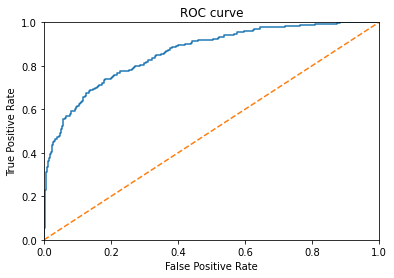

In [20]:
probabilities_valid = RandForestOpt.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()


It's great that you didn't forget the axis labels and the title to the graph.

### Area under True Positive Rate Curve
We see a beautiful deviation from the random model (orange line) that signifies that our model performs that much better than someone just working by chance. This is validated by the AUC we calculated.

#### Let's plot the precision-recall curve

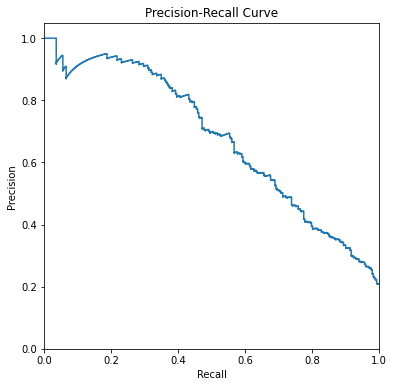

In [21]:
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show() 

The precision-recall curve is very high, which also signifies a high performance of the model. This, along with the ROC-AUC and F1 all signifiy that we have satisfactorily provided the company with a decent model to work with.

## The best model

The best model is a Random Forest Classifier. Bootstrap is set to true and the class_weight parameter is set to **' balanced '**. Setting it to balanced is very important otherwise the performance expectations are not met. 

The hyperparameters max_depth is set to 8 and n_estimators is set to 149. A  random_state = 12345 will give you the exact results I produced above.

For the test dataset, the F1 score is 0.64 and the AUC-ROC score is 0.87. Both these metrics signify good quality and meet the expectations of the assignment.

